In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import feature_selection

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors

#import seaborn as sns
from sqlalchemy import create_engine

In [2]:
import pandas as pd
%matplotlib inline

In [3]:
#sns.set_context(font_scale=1.2)

In [4]:
font = {'family'        : 'sans-serif',
        'sans-serif'    : ['Computer Modern Sans serif'],
        'weight'        : 'regular',
        'size'          : 12}

text = {'usetex'        : False}

plt.rc('font', **font)
plt.rc('text', **text)

In [5]:
engine = create_engine('sqlite:///../O2RBpipeline/Hi_threshO2rbogus-dev.db')

## Load the tables from the DB

Using a merge we can get the detected portion of the objects, with the
recovered data, and the correct simulated data.

In [6]:
dt_zps = pd.merge(pd.read_sql_table('Detected', engine),
                  pd.read_sql_query("""SELECT 
                                        Detected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM Detected
                                        LEFT JOIN Reals
                                            ON Detected.id==Reals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==Reals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_sps = pd.merge(pd.read_sql_table('SDetected', engine),
                  pd.read_sql_query("""SELECT 
                                        SDetected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM SDetected
                                        LEFT JOIN SReals
                                            ON SDetected.id==SReals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==SReals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_ois = pd.merge(pd.read_sql_table('DetectedOIS', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedOIS.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedOIS
                                        LEFT JOIN RealsOIS
                                            ON DetectedOIS.id==RealsOIS.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsOIS.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_hot = pd.merge(pd.read_sql_table('DetectedHOT', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedHOT.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedHOT
                                        LEFT JOIN RealsHOT
                                            ON DetectedHOT.id==RealsHOT.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsHOT.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [7]:
dt_ois['MAG'] = dt_ois['MAG_APER'] - 1.13079840595
dt_zps['MAG'] = dt_zps['MAG_APER'] - 3.60046548531
dt_hot['MAG'] = dt_hot['MAG_APER'] + 6.64070381825
dt_sps['MAG'] = -2.5*np.log10(dt_sps['cflux']) + 16.6023808276

In [8]:
dt_ois['MU'] = dt_ois.MAG/(dt_ois.A_IMAGE*dt_ois.B_IMAGE)
dt_zps['MU'] = dt_zps.MAG/(dt_zps.A_IMAGE*dt_zps.B_IMAGE)
dt_hot['MU'] = dt_hot.MAG/(dt_hot.A_IMAGE*dt_hot.B_IMAGE)
dt_sps['MU'] = dt_sps.MAG/(dt_sps.a*dt_sps.b)

In [9]:
dt_ois['SN'] = dt_ois.FLUX_APER/dt_ois.FLUXERR_APER
dt_zps['SN'] = dt_zps.FLUX_APER/dt_zps.FLUXERR_APER
dt_hot['SN'] = dt_hot.FLUX_APER/dt_hot.FLUXERR_APER
dt_sps['SN'] = dt_sps.cflux/np.sqrt(dt_sps.cflux)

* Mean magniutde difference for Zackay is 1.05939544157
* Mean magniutde difference for Bramich is 5.90741295815
* Mean magniutde difference for Hotpans is 5.82769360385

From notebook threesome

In [10]:
dt_ois.IS_REAL = dt_ois.IS_REAL.astype(int)
dt_zps.IS_REAL = dt_zps.IS_REAL.astype(int)
dt_hot.IS_REAL = dt_hot.IS_REAL.astype(int)
dt_sps.IS_REAL = dt_sps.IS_REAL.astype(int)

In [11]:
dt_ois.describe()

id       NUMBER      FLUX_ISO  FLUXERR_ISO      MAG_ISO  \
count  6226.00000  6226.000000  6.226000e+03  6226.000000  6226.000000   
mean   3113.50000    37.180373  6.750787e+04   335.396233    14.888647   
std    1797.43572    30.624159  2.556170e+05   534.622685     2.034025   
min       1.00000     1.000000  8.147530e+01     5.796899     8.010600   
25%    1557.25000    14.000000  3.021909e+03    45.523070    13.460150   
50%    3113.50000    30.000000  1.040022e+04   120.481300    14.957400   
75%    4669.75000    51.000000  4.129797e+04   391.520475    16.299300   
max    6226.00000   187.000000  6.248308e+06  5742.854000    20.222400   

        MAGERR_ISO     FLUX_APER  FLUXERR_APER     MAG_APER  MAGERR_APER  \
count  6226.000000  6.226000e+03   6226.000000  6226.000000  6226.000000   
mean      0.020851  1.945246e+04    226.954991    18.183492     3.070542   
std       0.018183  5.127213e+04    303.678415    14.483134    17.067828   
min       0.000100 -2.071749e+04      8.955538     9.904900     0.000100   
25%       0.006600  1.429686e+03     25.183550    14.338725     0.009900   
50%       0.016100  4.899229e+03     69.055765    15.774700     0.024400   
75%       0.029500  1.838664e+04    269.479900    17.111900     0.040500   
max       0.092900  1.091573e+06   1821.480000    99.000000    99.000000   

          ...             RATIO    ROUNDNESS  PEAK_CENTROID      IS_REAL  \
count     ...       6226.000000  6226.000000    6226.000000  6226.000000   
mean      ...          0.750427     1.672950       1.027965     0.216672   
std       ...          0.215018     0.664888       1.166254     0.412010   
min       ...          0.000000     1.000000       0.001487     0.000000   
25%       ...          0.600000     1.223821       0.438611     0.000000   
50%       ...          0.800000     1.456288       0.697019     0.000000   
75%       ...          0.923077     1.889788       1.289858     0.000000   
max       ...          1.000000     9.128065      24.665752     1.000000   

          image_id      sim_mag       sim_id          MAG           MU  \
count  6226.000000  1349.000000  1349.000000  6226.000000  6226.000000   
mean     57.823161    14.095287   778.228317    17.052693    15.244631   
std      34.642204     1.606222   495.721712    14.483134    36.312468   
min       1.000000     9.084335     1.000000     8.774102     0.036190   
25%      28.000000    12.936946   351.000000    13.207927     2.068883   
50%      59.000000    14.226301   720.000000    14.643902     4.934328   
75%      90.000000    15.357117  1195.000000    15.981102    13.076616   
max     113.000000    17.923970  1695.000000    97.869202   321.261822   

                SN  
count  6226.000000  
mean    136.965456  
std     337.959504  
min    -279.160357  
25%      26.785845  
50%      44.520754  
75%     109.230158  
max    7672.155157  

[8 rows x 52 columns]

In [12]:
dt_hot.describe()

id         NUMBER      FLUX_ISO   FLUXERR_ISO  \
count  163375.000000  163375.000000  1.633750e+05  1.633750e+05   
mean    81688.000000   13835.113610  6.598558e+17  4.108129e+11   
std     47162.444452   15729.829722  2.063036e+20  6.287009e+13   
min         1.000000       1.000000 -1.253902e+15  0.000000e+00   
25%     40844.500000     685.500000  1.506200e+05  9.056019e+00   
50%     81688.000000    7287.000000  2.329029e+06  2.456053e+03   
75%    122531.500000   23307.000000  7.943204e+07  3.559159e+03   
max    163375.000000   56563.000000  8.304641e+22  2.451905e+16   

             MAG_ISO    MAGERR_ISO     FLUX_APER  FLUXERR_APER       MAG_APER  \
count  163375.000000  1.633750e+05  1.633750e+05  1.633750e+05  163375.000000   
mean        9.683243  3.938733e+19  2.799135e+16  1.753482e+11      31.180825   
std         7.060310  1.591301e+22  3.656103e+18  5.036054e+12      38.741639   
min       -32.298300  0.000000e+00 -3.324319e+19  0.000000e+00     -27.215800   
25%         5.250000  0.000000e+00  5.651880e+00  7.955407e+00       6.260150   
50%         9.082100  1.000000e-04  4.678012e+05  3.434964e+03      10.824800   
75%        12.055300  2.000000e-03  3.132758e+07  3.452481e+03      23.119500   
max        99.000000  6.431985e+24  7.697105e+20  3.117538e+14      99.000000   

         MAGERR_APER      ...               RATIO      ROUNDNESS  \
count  163375.000000      ...       163375.000000  163375.000000   
mean       24.103038      ...            0.721348       1.898603   
std        42.480247      ...            0.217268       0.933952   
min         0.000000      ...            0.000000       1.000000   
25%         0.000000      ...            0.550000       1.332510   
50%         0.001300      ...            0.714286       1.647713   
75%         0.158450      ...            1.000000       2.187500   
max       271.862400      ...            1.000000      86.954577   

       PEAK_CENTROID        IS_REAL       image_id     sim_mag       sim_id  \
count  163375.000000  163375.000000  163375.000000  154.000000   154.000000   
mean        0.822632       0.000943      55.875024   14.834544   810.389610   
std         3.888202       0.030688      29.752112    1.683846   437.183952   
min         0.000000       0.000000       1.000000   10.105093   123.000000   
25%         0.320152       0.000000      34.000000   13.636316   497.250000   
50%         0.503702       0.000000      46.000000   15.021632   745.500000   
75%         0.853654       0.000000      95.000000   16.059453  1149.000000   
max      1148.345149       1.000000     113.000000   18.534565  1589.000000   

                 MAG             MU            SN  
count  163375.000000  163375.000000  1.633740e+05  
mean       37.821529      79.176974           NaN  
std        38.741639     119.687063           NaN  
min       -20.575096     -26.871708          -inf  
25%        12.900854      11.513796  6.857103e+00  
50%        17.465504      22.292612  8.227672e+02  
75%        29.760204      58.206534  3.320158e+04  
max       105.640704    1265.825151           inf  

[8 rows x 52 columns]

In [13]:
dt_zps.describe()

id        NUMBER       FLUX_ISO   FLUXERR_ISO       MAG_ISO  \
count  24723.000000  24723.000000   24723.000000  24723.000000  24723.000000   
mean   12362.000000    177.653521    1303.424921      5.436676     18.836832   
std     7137.059689    162.690822    5979.931342      4.523338      1.607483   
min        1.000000      1.000000     -80.715690      0.601714     11.926000   
25%     6181.500000     58.000000     112.062800      3.033567     18.070800   
50%    12362.000000    135.000000     233.709600      4.086380     19.078300   
75%    18542.500000    252.000000     591.128750      5.853549     19.876350   
max    24723.000000   1022.000000  169670.500000     66.276130     99.000000   

         MAGERR_ISO     FLUX_APER  FLUXERR_APER      MAG_APER   MAGERR_APER  \
count  24723.000000  24723.000000  24723.000000  24723.000000  24723.000000   
mean       0.026835    321.262356      4.341555     23.523434      5.233781   
std        0.629687   1266.034522      0.706923     17.509275     30.780622   
min        0.000100  -4238.958000      1.185239     13.276600      0.000100   
25%        0.010100     84.961050      4.316720     19.022200      0.019300   
50%        0.020100    131.234200      4.446121     19.704900      0.036000   
75%        0.032000    246.103400      4.576180     20.176950      0.054000   
max       99.000000  48904.120000      8.265847     99.000000   3425.829100   

           ...              RATIO     ROUNDNESS  PEAK_CENTROID      IS_REAL  \
count      ...       24723.000000  24723.000000   24723.000000  24723.00000   
mean       ...           0.637038      2.328983       1.180012      0.06047   
std        ...           0.258829      1.534272       2.597703      0.23836   
min        ...           0.000000      1.001629       0.000200      0.00000   
25%        ...           0.461538      1.480511       0.434593      0.00000   
50%        ...           0.666667      1.881387       0.700300      0.00000   
75%        ...           0.833333      2.704761       1.231500      0.00000   
max        ...           1.000000     62.656000     267.076843      1.00000   

           image_id      sim_mag       sim_id           MAG            MU  \
count  24723.000000  1495.000000  1495.000000  24723.000000  24723.000000   
mean      48.743275    14.326347   822.965886     19.922968     25.681787   
std       30.367419     1.709572   475.604292     17.509275     45.975233   
min        1.000000     9.084335     1.000000      9.676135      0.038444   
25%       21.000000    13.050975   414.500000     15.421735      5.990479   
50%       48.000000    14.520790   811.000000     16.104435     13.812680   
75%       76.000000    15.550479  1223.500000     16.576485     26.388152   
max      113.000000    18.534565  1695.000000     95.399535    435.018397   

                 SN  
count  24723.000000  
mean      79.797256  
std      351.389352  
min     -889.264775  
25%       20.101599  
50%       30.173892  
75%       56.357610  
max    15696.521005  

[8 rows x 52 columns]

In [14]:
dt_sps.describe()

id       thresh         npix        tnpix         xmin  \
count  7790.000000  7790.000000  7790.000000  7790.000000  7790.000000   
mean   3895.500000     0.019879   171.428241   171.428241  1166.035045   
std    2248.923631     0.036395   404.960497   404.960497   688.534509   
min       1.000000     0.000471     3.000000     3.000000     0.000000   
25%    1948.250000     0.007620     8.000000     8.000000   548.000000   
50%    3895.500000     0.013210    22.000000    22.000000  1159.500000   
75%    5842.750000     0.021618   118.750000   118.750000  1598.750000   
max    7790.000000     0.533730  5679.000000  5679.000000  3576.000000   

              xmax         ymin         ymax            x            y  \
count  7790.000000  7790.000000  7790.000000  7790.000000  7790.000000   
mean   1177.459307   842.375096   854.391014  1171.874718   848.504188   
std     689.864568   432.202818   431.962064   689.273990   432.079241   
min       0.000000     0.000000     1.000000     0.000000     0.567637   
25%     555.250000   535.000000   550.000000   550.817591   544.231212   
50%    1169.000000   845.000000   858.000000  1163.941496   851.340630   
75%    1620.750000  1200.000000  1212.000000  1611.478052  1205.990381   
max    3607.000000  3696.000000  3700.000000  3586.074548  3699.763169   

          ...             RATIO    ROUNDNESS  PEAK_CENTROID      IS_REAL  \
count     ...       7790.000000  7790.000000    7790.000000  7790.000000   
mean      ...          0.670055     3.010262       1.859045     0.144544   
std       ...          0.266597     2.512068       2.549812     0.351663   
min       ...          0.000000     1.000345       0.000371     0.000000   
25%       ...          0.500000     1.354681       0.628243     0.000000   
50%       ...          0.721576     2.034279       1.160798     0.000000   
75%       ...          0.888889     3.866164       2.127369     0.000000   
max       ...          1.000000    56.293833      45.850184     1.000000   

          image_id      sim_mag       sim_id          MAG           MU  \
count  7790.000000  1126.000000  1126.000000  7790.000000  7790.000000   
mean     53.375225    14.251298   859.664298    16.641696    14.456058   
std      27.501020     1.656362   448.241888     2.287499    17.435557   
min       1.000000     9.313603     3.000000     7.576935     0.027918   
25%      29.000000    12.976805   482.250000    15.219495     1.581661   
50%      54.000000    14.329574   843.000000    17.038013     7.271906   
75%      77.000000    15.430807  1235.750000    18.278810    21.720590   
max     113.000000    18.534565  1684.000000    22.962540   186.018546   

                SN  
count  7790.000000  
mean      1.880951  
std       3.251887  
min       0.053453  
25%       0.462077  
50%       0.818227  
75%       1.890502  
max      63.839454  

[8 rows x 43 columns]

In [15]:
dt_ois

id  NUMBER      FLUX_ISO  FLUXERR_ISO  MAG_ISO  MAGERR_ISO  \
0        1       1  6.926840e+02     28.22407  17.8987      0.0443   
1        2       2  7.272628e+02     28.99747  17.8458      0.0433   
2        3       3  8.735574e+03     81.74699  15.1468      0.0102   
3        4       4  1.425356e+04     99.11967  14.6152      0.0076   
4        5       5  1.653889e+04     96.63280  14.4537      0.0063   
5        6       6  8.029869e+02     28.22407  17.7382      0.0382   
6        7       7  4.655639e+02     21.03698  18.3301      0.0491   
7        8       8  2.764968e+02     16.29517  18.8958      0.0640   
8        9       9  7.427001e+03     78.71316  15.3230      0.0115   
9       10      10  2.134042e+04    108.08990  14.1770      0.0055   
10      11      11  9.933322e+03     86.22594  15.0073      0.0094   
11      12      12  5.808010e+02     24.89129  18.0899      0.0465   
12      13      13  1.487426e+03     36.43711  17.0689      0.0266   
13      14      14  1.809775e+03     35.82468  16.8559      0.0215   
14      15      15  1.240182e+04     94.31513  14.7663      0.0083   
15      16      16  4.516838e+03     63.11093  15.8629      0.0152   
16      17      17  3.212627e+03     45.60708  16.2328      0.0154   
17      18      18  1.971570e+03     41.00862  16.7630      0.0226   
18      19      19  1.992186e+02     14.87539  19.2517      0.0811   
19      20      20  9.379893e+04    157.84740  12.5695      0.0018   
20      21      21  9.520848e+02     23.98584  17.5533      0.0274   
21      22      22  1.201796e+04     92.17942  14.8004      0.0083   
22      23      23  8.331779e+02     24.89129  17.6982      0.0324   
23      24      24  3.260585e+03     23.04486  16.2168      0.0077   
24      25      25  1.703322e+03     31.90416  16.9218      0.0203   
25      26      26  1.580463e+04     99.78714  14.5030      0.0069   
26      27      27  1.095731e+03     25.76493  17.4007      0.0255   
27      28      28  3.155233e+03     38.79027  16.2524      0.0134   
28      29      29  2.650134e+02     16.29517  18.9418      0.0668   
29      30      30  1.254959e+04     89.99303  14.7534      0.0078   
...    ...     ...           ...          ...      ...         ...   
6196  6197      83  2.710151e+04    743.30270  13.9175      0.0298   
6197  6198      84  4.834640e+03    332.41510  15.7891      0.0747   
6198  6199      85  2.307501e+06   3314.16400   9.0921      0.0016   
6199  6200      86  3.084710e+04    814.24740  13.7770      0.0287   
6200  6201      87  2.338840e+04    630.71330  14.0775      0.0293   
6201  6202      88  2.065624e+04    647.99630  14.2124      0.0341   
6202  6203      89  5.496201e+03    332.41510  15.6498      0.0657   
6203  6204      90  1.352822e+04    514.97530  14.6719      0.0413   
6204  6205      91  3.199854e+04    840.95110  13.7372      0.0285   
6205  6206      92  1.680379e+04    594.64220  14.4365      0.0384   
6206  6207      93  8.866533e+04    963.43050  12.6306      0.0118   
6207  6208      94  2.371974e+04    630.71330  14.0622      0.0289   
6208  6209      95  1.522635e+04    536.00320  14.5435      0.0382   
6209  6210      96  2.878824e+04    697.27980  13.8520      0.0263   
6210  6211      97  2.377318e+04    575.75980  14.0598      0.0263   
6211  6212      98  4.800574e+03    332.41510  15.7968      0.0752   
6212  6213      99  1.936920e+05   1727.28000  11.7822      0.0097   
6213  6214     100  8.760206e+04    879.48770  12.6437      0.0109   
6214  6215     101  8.726329e+04    963.43050  12.6479      0.0120   
6215  6216     102  6.155072e+05   2729.04500  10.5269      0.0048   
6216  6217     103  9.978996e+03    420.47560  15.0023      0.0458   
6217  6218     104  6.051864e+03    364.14250  15.5453      0.0653   
6218  6219     105  1.622034e+04    556.23690  14.4748      0.0372   
6219  6220     106  1.758748e+04    514.97530  14.3870      0.0318   
6220  6221     107  5.382183e+03    332.41510  15.6726      0.0671   
6221  6222     108

/home/bruno/.virtualenvs/iPTF/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


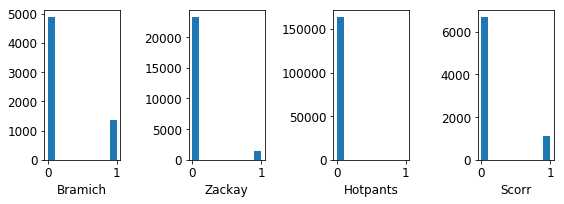

In [16]:
plt.figure(figsize=(8,3))
plt.subplot(141)
plt.hist(dt_ois['IS_REAL'])
plt.xlabel('Bramich')
plt.subplot(142)
plt.hist(dt_zps['IS_REAL'])
plt.xlabel('Zackay')
plt.subplot(143)
plt.hist(dt_hot['IS_REAL'])
plt.xlabel('Hotpants')
plt.subplot(144)
plt.hist(dt_sps['IS_REAL'])
plt.xlabel('Scorr')
plt.tight_layout()

## Select the columns 

We select for both methods the columns related to every detection recovered data. 

There are 35 columns relevant, and this would be the biggest features set for training and testing.
Also we perform a random sampling, to be ablo tohandle the data

In [17]:
d_ois = dt_ois[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', 'MAG', 'MU', 'SN']]

In [18]:
d_zps = dt_zps[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', 'MAG', 'MU', 'SN']]

In [19]:
d_hot = dt_hot[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', 'MAG', 'MU', 'SN']]

In [20]:
dt_sps.columns

Index([           u'id',        u'thresh',          u'npix',         u'tnpix',
                u'xmin',          u'xmax',          u'ymin',          u'ymax',
                   u'x',             u'y',            u'x2',            u'y2',
                  u'xy',         u'errx2',         u'erry2',         u'errxy',
                   u'a',             u'b',         u'theta',           u'cxx',
                 u'cyy',           u'cxy',         u'cflux',          u'flux',
               u'cpeak',          u'peak',        u'xcpeak',        u'ycpeak',
               u'xpeak',         u'ypeak',          u'flag',        u'DELTAX',
              u'DELTAY',         u'RATIO',     u'ROUNDNESS', u'PEAK_CENTROID',
             u'IS_REAL',      u'image_id',       u'sim_mag',        u'sim_id',
                 u'MAG',            u'MU',            u'SN'],
      dtype='object')

In [21]:
d_sps = dt_sps[[u'thresh', u'npix', u'tnpix', u'xmin', u'xmax', u'ymin', u'ymax', u'x', u'y', u'x2', u'y2',
                  u'xy', u'errx2', u'erry2', u'errxy', u'a', u'b', u'theta', u'cxx', u'cyy', u'cxy', u'cflux',          u'flux',
               u'cpeak', u'peak', u'xcpeak', u'ycpeak', u'xpeak', u'ypeak', u'flag', u'DELTAX',
              u'DELTAY', u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', u'MAG', u'MU', u'SN']]

In [22]:
len(d_zps.columns)

38

In [23]:
print d_zps.columns

Index([     u'FLUX_ISO',   u'FLUXERR_ISO',       u'MAG_ISO',    u'MAGERR_ISO',
           u'FLUX_APER',  u'FLUXERR_APER',      u'MAG_APER',   u'MAGERR_APER',
           u'FLUX_AUTO',  u'FLUXERR_AUTO',      u'MAG_AUTO',   u'MAGERR_AUTO',
          u'BACKGROUND',     u'THRESHOLD',      u'FLUX_MAX',      u'X2_IMAGE',
            u'Y2_IMAGE',      u'XY_IMAGE',     u'CXX_IMAGE',     u'CYY_IMAGE',
           u'CXY_IMAGE',       u'A_IMAGE',       u'B_IMAGE',   u'THETA_IMAGE',
              u'MU_MAX',         u'FLAGS',    u'FWHM_IMAGE',    u'ELONGATION',
         u'ELLIPTICITY',    u'CLASS_STAR',        u'DELTAX',        u'DELTAY',
               u'RATIO',     u'ROUNDNESS', u'PEAK_CENTROID',           u'MAG',
                  u'MU',            u'SN'],
      dtype='object')


### Preprocesing
If we convert this to matrix (numpy arrays) we can then *preprocess* this data to become Machine treatable.

In [24]:
np.sum(np.sum(d_hot==np.nan))

0L

In [25]:
d_ois = d_ois.replace([np.inf, -np.inf], np.nan)
d_hot = d_hot.replace([np.inf, -np.inf], np.nan)
d_zps = d_zps.replace([np.inf, -np.inf], np.nan)
d_sps = d_sps.replace([np.inf, -np.inf], np.nan)

In [26]:
d_ois.dropna(inplace=True)
d_hot.dropna(inplace=True)
d_zps.dropna(inplace=True)
d_sps.dropna(inplace=True)

### Scaled

This scaling process transforms data to match distributions with zero mean and unit variance.

In [27]:
X_zps = d_zps.as_matrix()
X_ois = d_ois.as_matrix()
X_hot = d_hot.as_matrix()
X_sps = d_sps.as_matrix()

In [28]:
scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)
scaler_sps = preprocessing.StandardScaler().fit(X_sps)

In [29]:
X_ois_scaled = scaler_ois.transform(X_ois)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)
X_sps_scaled = scaler_sps.transform(X_sps)

# Feature selection

Choosing a ranker
-----------------

It is important to know that feature selection is a general term for tossing the descriptors that doesn't work
as expected. This is not always mentioned, but in general one firstly should decide which ML algorithm will use,
for example a support vector machines. So, select a feature should be introduced tied to the algorithm applied for selection and perfomance testing. 

If it is not like this, one could provide misleading information, like jumping to the conclusion that there is no relation at all between a poor performer feature and the objective class, since the method for ML may be somehow not able to grab the information the feature provides. 

A quick notion of this is the non-linearities present in the profound behaviour of the reality, that we want to learn using linear kernels in a Support VM algorithm.

In [30]:
Y_sps = dt_sps['IS_REAL']
Y_ois = dt_ois['IS_REAL']
Y_zps = dt_zps['IS_REAL']
Y_hot = dt_hot['IS_REAL']

In [31]:
Y_ois = dt_ois.iloc[d_ois.index]['IS_REAL']
Y_sps = dt_sps.iloc[d_sps.index]['IS_REAL']
Y_zps = dt_zps.iloc[d_zps.index]['IS_REAL']
Y_hot = dt_hot.iloc[d_hot.index]['IS_REAL']

In [32]:
print len(X_ois_scaled), len(Y_ois)
print len(X_zps_scaled), len(Y_zps)
print len(X_hot_scaled), len(Y_hot)
print len(X_sps_scaled), len(Y_sps)

6226 6226
24723 24723
163349 163349
7790 7790


In [33]:
fraction_reals_ois = sum(Y_ois)/float(len(Y_ois))
fraction_bogus_ois = 1. - fraction_reals_ois

In [34]:
print 'The fraction of reals is: {}'.format(fraction_reals_ois)
print 'The fraction of bogus is: {}'.format(fraction_bogus_ois)
print '\n'
print 'The ratio is: {}'.format(fraction_reals_ois/fraction_bogus_ois)

The fraction of reals is: 0.216672020559
The fraction of bogus is: 0.783327979441


The ratio is: 0.276604469961


In [35]:
fraction_reals_zps = sum(Y_zps)/float(len(Y_zps))
fraction_bogus_zps = 1. - fraction_reals_zps

In [36]:
print 'The fraction of reals is: {}'.format(fraction_reals_zps)
print 'The fraction of bogus is: {}'.format(fraction_bogus_zps)
print '\n'
print 'The ratio is: {}'.format(fraction_reals_zps/fraction_bogus_zps)

The fraction of reals is: 0.0604700076852
The fraction of bogus is: 0.939529992315


The ratio is: 0.0643619769244


In [37]:
fraction_reals_hot = sum(Y_hot)/float(len(Y_hot))
fraction_bogus_hot = 1. - fraction_reals_hot

In [38]:
print 'The fraction of reals is: {}'.format(fraction_reals_hot)
print 'The fraction of bogus is: {}'.format(fraction_bogus_hot)
print '\n'
print 'The ratio is: {}'.format(fraction_reals_hot/fraction_bogus_hot)

The fraction of reals is: 0.000930522990652
The fraction of bogus is: 0.999069477009


The ratio is: 0.000931389670153


In [39]:
fraction_reals_sps = sum(Y_sps)/float(len(Y_sps))
fraction_bogus_sps = 1. - fraction_reals_sps

In [40]:
print 'The fraction of reals is: {}'.format(fraction_reals_sps)
print 'The fraction of bogus is: {}'.format(fraction_bogus_sps)
print '\n'
print 'The ratio is: {}'.format(fraction_reals_sps/fraction_bogus_sps)

The fraction of reals is: 0.144544287548
The fraction of bogus is: 0.855455712452


The ratio is: 0.168967587035


### Univariate selection (*f-test* + *SelectPercentile*)

In [41]:
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, chi2

In [42]:
percentile = 50.

/home/bruno/.virtualenvs/iPTF/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/bruno/.virtualenvs/iPTF/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/bruno/.virtualenvs/iPTF/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.r

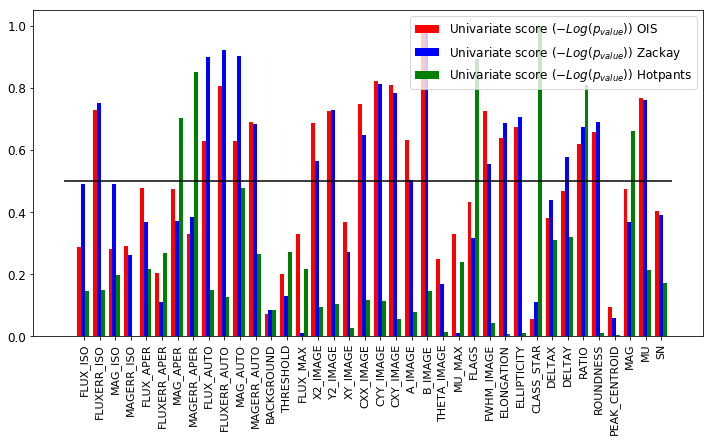

In [43]:
plt.figure(figsize=(12, 6))
#plt.subplot(131)
selector = SelectPercentile(mutual_info_classif, percentile=percentile)
selector.fit(X_ois_scaled, Y_ois)
scores = selector.scores_ #-np.log10(selector.pvalues_)
scores /= scores.max()

ois_selected_cols = selector.transform(np.arange(X_ois_scaled.shape[-1]))

plt.bar(np.arange(X_ois_scaled.shape[-1]), scores, width=.25,
        label=r'Univariate score ($-Log(p_{value})$) OIS', color='red')
plt.xticks(np.arange(X_ois_scaled.shape[-1])+0.3, d_ois.columns, rotation='vertical', fontsize=11)
#plt.title('OIS')

#plt.subplot(132)
selector = SelectPercentile(mutual_info_classif, percentile=percentile)
selector.fit(X_zps_scaled, Y_zps)
scores = selector.scores_ #-np.log10(selector.pvalues_)
scores /= scores.max()

zps_selected_cols = selector.transform(np.arange(X_zps_scaled.shape[-1]))

plt.bar(np.arange(X_zps_scaled.shape[-1])+0.25, scores, width=.25,
        label=r'Univariate score ($-Log(p_{value})$) Zackay', color='blue')
#plt.xticks(np.arange(X_zps_scaled.shape[-1]), dt_zps.columns, rotation='vertical', fontsize=9)
#plt.title('Zackay')

#plt.subplot(133)
selector = SelectPercentile(mutual_info_classif, percentile=percentile)
selector.fit(X_hot_scaled, Y_hot)
scores = selector.scores_ #-np.log10(selector.pvalues_)
scores /= scores.max()

hot_selected_cols = selector.transform(np.arange(X_hot_scaled.shape[-1]))

plt.bar(np.arange(X_hot_scaled.shape[-1])+0.5, scores, width=.25,
        label=r'Univariate score ($-Log(p_{value})$) Hotpants', color='green')
#plt.xticks(np.arange(X_hot_scaled.shape[-1]), dt_hot.columns, rotation='vertical', fontsize=9)
#plt.title('Hotpants')
plt.legend(loc='best')
plt.hlines(y=percentile/100., xmin=-1, xmax=38)

plt.show()

/home/bruno/.virtualenvs/iPTF/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


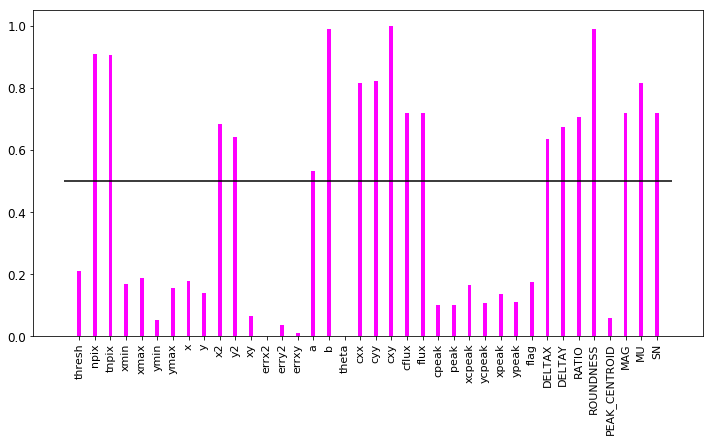

In [44]:
#plt.subplot(132)
plt.figure(figsize=(12, 6))
selector = SelectPercentile(mutual_info_classif, percentile=percentile)
selector.fit(X_sps_scaled, Y_sps)
scores = selector.scores_ #-np.log10(selector.pvalues_)
scores /= scores.max()

sps_selected_cols = selector.transform(np.arange(X_sps_scaled.shape[-1]))

plt.bar(np.arange(X_sps_scaled.shape[-1]), scores, width=.25,
        label=r'Univariate score ($-Log(p_{value})$) Scorr', color='magenta')
plt.xticks(np.arange(X_sps_scaled.shape[-1]), d_sps.columns, rotation='vertical', fontsize=11)
#plt.title('OIS')
plt.hlines(y=percentile/100., xmin=-1, xmax=38)

plt.show()

### Scaled

This scaling process transforms data to match distributions with zero mean and unit variance.

In [45]:
d_zps = d_zps[d_zps.columns[zps_selected_cols][0]]
d_ois = d_ois[d_ois.columns[ois_selected_cols][0]]
d_hot = d_hot[d_hot.columns[hot_selected_cols][0]]
d_sps = d_sps[d_sps.columns[sps_selected_cols][0]]

In [46]:
X_zps = d_zps.as_matrix()
X_ois = d_ois.as_matrix()
X_hot = d_hot.as_matrix()
X_sps = d_sps.as_matrix()

In [47]:
scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_sps = preprocessing.StandardScaler().fit(X_sps)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)

In [48]:
X_sps_scaled = scaler_sps.transform(X_sps)
X_ois_scaled = scaler_ois.transform(X_ois)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)

**Recursive feature elimination**

This a feature selection technique, that is completely supervised (in opposition to a Principal Component Analisys), and aims to elminate features that have poor description power in the chosen model environment.

For example in the code block below, we use a *c45* decision tree, and a *step* value of 3. This means, that we will train a *c45* algorithm tossing three random features, repeteadly, until we get a notion of which set of features get better scores (*f1* in this case). We repeat this using a 10 fold cross validation, and then decide which features we eliminate.

So it is a recursive technique that depends strongly on the *c45* election. It is clear that features that perform poor on a decision tree can be good descriptors for SVM for example. 

### OIS

In [49]:
svc = SVC(kernel='linear', 
          cache_size=600, 
          class_weight='balanced', 
          probability=False)

In [67]:
rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=StratifiedKFold(6),
              scoring='f1', n_jobs=3)
%time rfecv.fit(np.ascontiguousarray(X_ois_scaled), Y_ois)

CPU times: user 10.8 s, sys: 716 ms, total: 11.5 s
Wall time: 1min 3s


RFECV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
   estimator=SVC(C=1.0, cache_size=600, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=3, scoring='f1', step=1, verbose=0)

In [68]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 15


In [69]:
import gc
gc.collect()

443

In [70]:
d_ois.columns[rfecv.support_]

Index([ u'FLUXERR_ISO',    u'FLUX_APER', u'FLUXERR_AUTO',     u'MAG_AUTO',
        u'MAGERR_AUTO',     u'X2_IMAGE',     u'Y2_IMAGE',      u'A_IMAGE',
            u'B_IMAGE',   u'FWHM_IMAGE',   u'ELONGATION',  u'ELLIPTICITY',
              u'RATIO',    u'ROUNDNESS',           u'MU'],
      dtype='object')

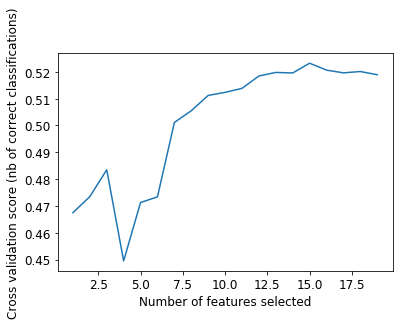

In [71]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [72]:
dB = d_ois[d_ois.columns[rfecv.support_]]

In [73]:
if rfecv.n_features_< 10:
    pd.scatter_matrix(dB, alpha=0.1, figsize=(8, 8), diagonal='kde')
    plt.show()

### Zackay

In [74]:
svc = SVC(kernel='linear', 
          cache_size=600, 
          class_weight='balanced', 
          probability=False)

In [75]:
c45 = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=33)

In [ ]:
rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=StratifiedKFold(6),
              scoring='f1', n_jobs=3)

In [ ]:
rfecv.fit(np.ascontiguousarray(X_zps_scaled), Y_zps)

In [ ]:
gc.collect()

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

In [ ]:
d_zps.columns[rfecv.support_]

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
dZ = d_zps[d_zps.columns[rfecv.support_]]

In [ ]:
if sum(rfecv.support_)< 10:
    pd.scatter_matrix(dZ, alpha=0.1, figsize=(10, 10), diagonal='kde')
    plt.grid()
    plt.show()

##  $S_{Corr}$

In [177]:
svc = SVC(kernel='linear', 
          cache_size=600, 
          class_weight='balanced', 
          probability=False)

In [178]:
rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=StratifiedKFold(6),
              scoring='f1', n_jobs=7)

In [179]:
rfecv.fit(np.ascontiguousarray(X_sps_scaled), Y_sps)

RFECV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
   estimator=SVC(C=1.0, cache_size=600, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=7, scoring='f1', step=1, verbose=0)

In [180]:
gc.collect()

363

In [181]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 16


In [182]:
d_sps.columns[rfecv.support_]

Index([   u'thresh',     u'tnpix',        u'x2',        u'y2',         u'a',
               u'b',       u'cxx',     u'cflux',      u'flux',    u'DELTAX',
          u'DELTAY',     u'RATIO', u'ROUNDNESS',       u'MAG',        u'MU',
              u'SN'],
      dtype='object')

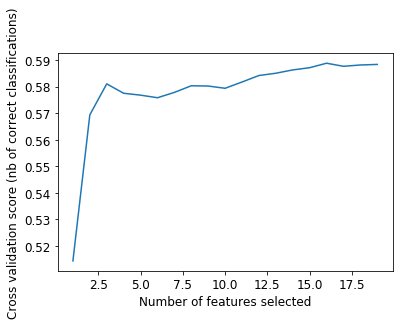

In [183]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [184]:
dS = d_sps[d_sps.columns[rfecv.support_]]

In [185]:
if sum(rfecv.support_)< 10:
    pd.scatter_matrix(dS, alpha=0.1, figsize=(10, 10), diagonal='kde')
    plt.grid()
    plt.show()

### HOTPANTS

In [186]:
svc = SVC(kernel='linear', 
          cache_size=600, 
          class_weight='balanced', 
          probability=False)

In [ ]:
rfecv = feature_selection.RFECV(estimator=svc, step=3, cv=StratifiedKFold(6),
              scoring='f1', n_jobs=3)

In [ ]:
rfecv.fit(np.ascontiguousarray(X_hot_scaled), Y_hot)

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

In [ ]:
d_hot.columns[rfecv.support_]

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
dH = d_hot[d_hot.columns[rfecv.support_]]

In [ ]:
if rfecv.n_features_ < 7:
    pd.scatter_matrix(dH, alpha=0.1, figsize=(12, 12), diagonal='kde')
    plt.show()

In [ ]:
gc.collect()

## Post processing

Repeat the scaling pre processing so we get the selected features normalized

In [ ]:
X_zps = dZ.as_matrix()
X_sps = dS.as_matrix()
X_ois = dB.as_matrix()
X_hot = dH.as_matrix()

scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_sps = preprocessing.StandardScaler().fit(X_sps)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)

X_ois_scaled = scaler_ois.transform(X_ois)
X_sps_scaled = scaler_sps.transform(X_sps)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)

## Univariate feature selection

### ANOVA

In [ ]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

transform = SelectPercentile(f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0, 
                                                      cache_size=500, 
                                                      class_weight='balanced') )])

In [ ]:
def anova_svm(X, y, clf, title=None):
    score_means = list()
    score_stds = list()
    percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

    for percentile in percentiles:
        clf.set_params(anova__percentile=percentile)
        # Compute cross-validation score using 1 CPU
        this_scores = cross_val_score(clf, X, y, n_jobs=4)
        score_means.append(this_scores.mean())
        score_stds.append(this_scores.std())

    plt.errorbar(percentiles, score_means, np.array(score_stds))

    if title is None:
        plt.title(
            'Performance of the SVM-Anova varying the percentile of features selected')
    else:
        plt.title(title)
    plt.xlabel('Percentile')
    plt.ylabel('Prediction rate')

    plt.axis('tight')
    #plt.show()

In [ ]:
plt.figure(figsize=(12, 3))
plt.subplot(141)
anova_svm(np.ascontiguousarray(X_ois_scaled), Y_ois, clf, title='SVM-Anova OIS')
plt.subplot(142)
anova_svm(np.ascontiguousarray(X_zps_scaled), Y_zps, clf, title='SVM-Anova Zackay')
plt.subplot(143)
anova_svm(np.ascontiguousarray(X_hot_scaled), Y_hot, clf, title='SVM-Anova Hotpants')
plt.subplot(144)
anova_svm(np.ascontiguousarray(X_sps_scaled), Y_sps, clf, title='SVM-Anova Scorr')
plt.tight_layout()
plt.show()

In [ ]:
gc.collect()

### Feature importance by random forest


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
def importance_forest(X, y, forest, cols=None, method=None):
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    if cols is not None:
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, cols[indices[f]-1], importances[indices[f]]))
    else:
        for f in range(X.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    #plt.figure(figsize=(6, 6))
    plt.title("Feature importances {}".format(method))
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    if cols is not None:
        plt.xticks(range(X.shape[1]), cols[indices-1], rotation='vertical', fontsize=10)
    else:
        plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    #plt.show()
    return [(cols[indices[f]-1], importances[indices[f]]) for f in range(X.shape[1])]

In [ ]:
plt.figure(figsize=(12, 3))
plt.subplot(141)
ois_importance = importance_forest(X_ois_scaled, Y_ois, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                 cols=dB.columns, method='OIS')
plt.subplot(142)
zps_importance = importance_forest(X_zps_scaled, Y_zps, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                                   cols=dZ.columns, method='Zackay')
plt.subplot(143)
hot_importance = importance_forest(X_hot_scaled, Y_hot, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                                   cols=dH.columns, method='Hotpants')
plt.subplot(144)
sps_importance = importance_forest(X_sps_scaled, Y_sps, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                                   cols=dS.columns, method='Scorr')

In [ ]:
acum=0
feats = []
for feat, imp in ois_importance:
    acum += imp
    feats.append(feat)
    if acum > .90: break

print acum, feats

In [ ]:
dB = dB[feats]

In [ ]:
acum=0
feats = []
for feat, imp in zps_importance:
    acum += imp
    feats.append(feat)
    if acum > .90: break

print acum, feats

In [ ]:
dZ = dZ[feats]

In [ ]:
acum=0
feats = []
for feat, imp in hot_importance:
    acum += imp
    feats.append(feat)
    if acum > .90: break

print acum, feats

In [ ]:
dH = dH[feats]

In [ ]:
acum=0
feats = []
for feat, imp in sps_importance:
    acum += imp
    feats.append(feat)
    if acum > .90: break

print acum, feats

In [ ]:
dS = dS[feats]

### Principal Component Analysis

In [ ]:
X_zps = dZ.as_matrix()
X_sps = dS.as_matrix()
X_ois = dB.as_matrix()
X_hot = dH.as_matrix()

scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_sps = preprocessing.StandardScaler().fit(X_sps)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)

X_ois_scaled = scaler_ois.transform(X_ois)
X_sps_scaled = scaler_sps.transform(X_sps)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)

**OIS**

In [ ]:
pca = decomposition.PCA(svd_solver='randomized', n_components=min(X_ois_scaled.shape[-1], 6))

pca.fit(X_ois_scaled)

In [ ]:
X_ois_t = pca.transform(X_ois_scaled)

In [ ]:
pd.scatter_matrix(pd.DataFrame(X_ois_t), alpha=0.1, figsize=(8, 8), diagonal='kde')
plt.grid()
plt.show()

**Zackay**

In [ ]:
pca = decomposition.PCA(svd_solver='randomized', n_components=min(X_zps_scaled.shape[-1], 6))

pca.fit(X_zps_scaled)

In [ ]:
X_zps_t = pca.transform(X_zps_scaled)

In [ ]:
pd.scatter_matrix(pd.DataFrame(X_zps_t), alpha=0.1, figsize=(8, 8), diagonal='kde')
plt.show()

**HOTPANTS**

In [ ]:
pca = decomposition.PCA(svd_solver='randomized', n_components=min(X_hot_scaled.shape[-1], 6))

pca.fit(X_hot_scaled)

In [ ]:
X_hot_t = pca.transform(X_hot_scaled)

In [ ]:
pd.scatter_matrix(pd.DataFrame(X_hot_t), alpha=0.1, figsize=(8, 8), diagonal='kde')
plt.grid()
plt.show()

**$S_{corr}$**

In [ ]:
pca = decomposition.PCA(svd_solver='randomized', n_components=min(X_sps_scaled.shape[-1], 6))

pca.fit(X_sps_scaled)

In [ ]:
X_sps_t = pca.transform(X_sps_scaled)

In [ ]:
pd.scatter_matrix(pd.DataFrame(X_sps_t), alpha=0.1, figsize=(8, 8), diagonal='kde')
plt.grid()
plt.show()

# Machine Learning perfomance comparison

## Comparing methods algorithm to algorithm

In [ ]:
def experiment(clf, x, y, nfolds=10, printing=False):
    skf = StratifiedKFold(n_splits=nfolds)
    probabilities = None # np.array([])
    predictions = np.array([])
    y_testing = np.array([])
    
    for train, test in skf.split(x, y):
        
        x_train = x[train]
        y_train = y[train]
        clf.fit(x_train, y_train)

        x_test = x[test]
        y_test = y[test]
        pr = clf.predict(x_test)
        probs = clf.predict_proba(x_test)  #[:, 0]
        
        probabilities = (
            probs if probabilities is None else
            np.vstack([probabilities, probs]))
        predictions = np.hstack([predictions, pr])
        y_testing = np.hstack([y_testing, y_test])

    if printing: 
        print metrics.classification_report(y_testing, predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y_testing, 1.-probabilities[:, 0])
    prec_rec_curve = metrics.precision_recall_curve(y_testing, 1.- probabilities[:, 0])
    roc_auc = metrics.auc(fpr, tpr)
    return {'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'prec_rec_curve': prec_rec_curve,
            'y_test': y_testing, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_testing, predictions),
            }

### K-Nearest Neighbors


**OIS**

In [ ]:
rslts_knn_ois_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [ ]:
rslts_knn_zps_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [ ]:
rslts_knn_hot_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_hot_scaled, Y_hot.as_matrix())

**$S_{corr}$**

In [ ]:
rslts_knn_sps_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_sps_scaled, Y_sps.as_matrix())

### Support vector machines

**OIS**

In [ ]:
rslts_ois_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [ ]:
rslts_zps_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [ ]:
rslts_hot_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_hot_scaled, Y_hot.as_matrix())

**$S_{corr}$**

In [ ]:
rslts_sps_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_sps_scaled, Y_sps.as_matrix())

### Decision tree (gini)

**OIS**

In [ ]:
rslts_ois_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [ ]:
rslts_zps_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [ ]:
rslts_hot_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_hot_scaled, Y_hot.as_matrix())

**$S_{corr}$**

In [ ]:
rslts_sps_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_sps_scaled, Y_sps.as_matrix())

### Random forest

**OIS**

In [ ]:
rslts_ois_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [ ]:
rslts_zps_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [ ]:
rslts_hot_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_hot_scaled, Y_hot.as_matrix())

**$S_{corr}$**

In [ ]:
rslts_sps_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_sps_scaled, Y_sps.as_matrix())

### DecisionTreeClassifier (C45)

**OIS**

In [ ]:
rslts_ois_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [ ]:
rslts_zps_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [ ]:
rslts_hot_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_hot_scaled, Y_hot.as_matrix())

**$S_{corr}$**

In [ ]:
rslts_sps_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_sps_scaled, Y_sps.as_matrix())

In [ ]:
gc.collect()

### ROC curve

In [ ]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sps = ['Scorr']

sub_methods = [zky, bch, hot, sps]

colors = ['blue', 'red', 'darkgreen', 'magenta']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest, rslts_sps_rforest],
              'DTree': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini, rslts_sps_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45, rslts_sps_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc, rslts_sps_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform, rslts_knn_sps_uniform]}#,
              #'SVMRBF'    : [rslts_zps_rbfsvc, rslts_ois_rbfsvc, rslts_hot_rbfsvc]}

del ml_methods['SVM']
del ml_methods['C45']

ls = ['-', '.-', '--', '-.', ':', '.']
j = 0
plt.figure(figsize=(10, 10))
for k, v in ml_methods.iteritems():
    for i in range(4):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        roc_auc = sub_method['roc_auc']
        sub_meth_col.append(roc_auc)
        
        label = sub_meth_col[0]+' '+k+' AUC={:06.4f}'.format(roc_auc)
        plt.plot(fpr, tpr, ls[j], lw=1.5, color=colors[i], label=label)
    j+=1

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right', fontsize=16)
plt.title('Receiver Operating Characteristic Curve', fontsize=16)

plt.xlim([-0.01, 0.50])
plt.ylim([0.5, 1.005])
plt.savefig('roc_without_pca.png')

In [ ]:
plt.figure(figsize=(8, 8))
#plt.figaspect(.8)
plt.subplot(221)
res_Dtree = rslts_ois_dtree_gini
res_C45 = rslts_ois_c45
res_Rforest = rslts_ois_rforest
res_svc = rslts_ois_svc
res_knn = rslts_knn_ois_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve OIS')

plt.subplot(222)
res_Dtree = rslts_zps_dtree_gini
res_C45 = rslts_zps_c45
res_Rforest = rslts_zps_rforest
res_svc = rslts_zps_svc
res_knn = rslts_knn_zps_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve Zackay')


plt.subplot(223)
res_Dtree = rslts_hot_dtree_gini
res_C45 = rslts_hot_c45
res_Rforest = rslts_hot_rforest
res_svc = rslts_hot_svc
res_knn = rslts_knn_hot_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve HOTPANTS')

plt.subplot(224)
res_Dtree = rslts_sps_dtree_gini
res_C45 = rslts_sps_c45
res_Rforest = rslts_sps_rforest
res_svc = rslts_sps_svc
res_knn = rslts_knn_sps_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve SCorr')

plt.tight_layout()

plt.savefig('prec_rec_without_pca.png')

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          printcm=False, 
                          colorbar=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if colorbar:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if printcm:
            print(cm)
            print("Normalized confusion matrix")
    else:
        if printcm:
            print(cm)
            print('Confusion matrix, without normalization')

    thresh = 0.74 #cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
m_coll = []

res_Dtree = rslts_ois_dtree_gini
res_C45 = rslts_ois_c45
res_Rforest = rslts_ois_rforest
res_svc = rslts_ois_svc
res_knn = rslts_knn_ois_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])

res_Dtree = rslts_zps_dtree_gini
res_C45 = rslts_zps_c45
res_Rforest = rslts_zps_rforest
res_svc = rslts_zps_svc
res_knn = rslts_knn_zps_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])
 
res_Dtree = rslts_hot_dtree_gini
res_C45 = rslts_hot_c45
res_Rforest = rslts_hot_rforest
res_svc = rslts_hot_svc
res_knn = rslts_knn_hot_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])

res_Dtree = rslts_sps_dtree_gini
res_C45 = rslts_sps_c45
res_Rforest = rslts_sps_rforest
res_svc = rslts_sps_svc
res_knn = rslts_knn_sps_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])
names = ['OIS', 'Zackay', 'Hotpants', 'SCorr']

plt.figure(figsize=(10, 10))
for k, methods in enumerate(m_coll):
    kappa_agreement = np.ones((len(methods), len(methods)))

    for i in range(len(methods)):
        for j in range(i+1):
            kappa_agreement[i, j] = metrics.cohen_kappa_score(methods[i]['predictions'],
                                                              methods[j]['predictions'])#, 
                                                              #labels=['star', 'galaxy'])
            kappa_agreement[j, i] = kappa_agreement[i, j]
    kappa_agreement[-1, -1] = 0
    plt.subplot(2, 2, k+1)
    
    plot_confusion_matrix(np.round(kappa_agreement, 3), 
                          classes=['C45', 'DTree', 'KNN', 'RForest', 'SVC', 'TrueLabels'],
                          title=r'Cohen $\kappa$ agreement')
    #plt.tight_layout()
    plt.xlabel(names[k])
    plt.ylabel('')


plt.savefig('cohen_without_pca.png')

In [ ]:
aucs = pd.DataFrame([zky, bch, hot, sps], columns=['SubMethod','DTreeGini', 'RForest', 'KNN'], )

In [ ]:
AUCTable = aucs.set_index(['SubMethod'])

In [ ]:
AUCTable

In [ ]:
(1-AUCTable).plot.barh(log=False, cmap='Accent')
plt.xlabel(r'$1-AUC$', fontsize=16)
plt.ylabel('Subtraction Method', fontsize=14)
plt.tight_layout()
plt.xlim(0, 0.3)
plt.legend(loc='best', fontsize=12)
plt.savefig('./plots/complementary_AUC2.png', dpi=600)

## Cost curves

In [ ]:
fpr = rslts_knn_hot_uniform['fpr']
tpr = rslts_knn_hot_uniform['tpr']
thr = rslts_knn_hot_uniform['thresh']
plt.figure()
prev_thr = 1.
for fp, tp, th in zip(fpr, tpr, thr):
    if (prev_thr-th) >= 0.:
        x_ax = np.linspace(0,1,10)
        y_ax = (1-tp-fp)*x_ax + fp

        plt.plot(x_ax, y_ax, 'k-', alpha=1)
        prev_thr = th

In [ ]:
print tpr[-10:]

In [ ]:
def cost_curve(fpr, tpr):
    prev_fp = 0.
    prev_tp = 0.

    p_plus = [0.]
    er = [0.]
    for fp, tp in zip(fpr, tpr):
        delta_fp = fp - prev_fp
        if delta_fp != 0.:
            slp = (tp - prev_tp)/(delta_fp)
            tp_0= prev_tp - slp*prev_fp
            p_plus.append(1./(1.+slp))
            er.append(p_plus[-1]*(1-tp_0))

    p_plus.append(1.)
    er.append(0.)
    return(p_plus, er)

In [ ]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sps = ['SCorr']
sub_methods = [zky, bch, hot, sps]

colors = ['blue', 'red', 'darkgreen', 'magenta']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest, rslts_sps_rforest],
              'DTree': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini, rslts_sps_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45, rslts_sps_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc, rslts_sps_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform, rslts_knn_sps_uniform]}#,
              #'SVMRBF'    : [rslts_zps_rbfsvc, rslts_ois_rbfsvc, rslts_hot_rbfsvc]}

ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(6, 6))
for k, v in ml_methods.iteritems():
    for i in range(4):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        p_plus, er = cost_curve(fpr, tpr)
        
        sub_meth_col.append(roc_auc)
        
        label = sub_meth_col[0]+' '+k+' AUC={:06.4f}'.format(roc_auc)
        plt.plot(p_plus, er, ls[j], lw=1.5, color=colors[i], label=label)
    j+=1

plt.xlabel('Probability of Positive')
plt.ylabel('Error Rate')
plt.legend(loc='upper left', fontsize=11)
plt.title('Cost Curve')

plt.xlim(0, 1)
plt.ylim(0, 1)


In [ ]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sps = ['SCorr']
sub_methods = [zky, bch, hot, sps]

colors = ['blue', 'red', 'darkgreen', 'magenta']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest, rslts_sps_rforest],
              'DTree': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini, rslts_sps_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45, rslts_sps_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc, rslts_sps_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform, rslts_knn_sps_uniform]}#,
              #'SVMRBF'    : [rslts_zps_rbfsvc, rslts_ois_rbfsvc, rslts_hot_rbfsvc]}

ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(26, 5))
for k, v in ml_methods.iteritems():
    plt.subplot(1, 5, j+1)
    plt.title(k)
    for i in range(4):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        thr = sub_method['thresh']
        prev_thr = 1.
        if k=='KNN':
            alpha = 1
        else: alpha=0.1
        for fp, tp, th in zip(fpr, tpr, thr):
            if (prev_thr-th) >= 0.005:
                x_ax = np.linspace(0,1,10)
                y_ax = (1-tp-fp)*x_ax + fp

                plt.plot(x_ax, y_ax, '-', color=colors[i], alpha=alpha)
                prev_thr = th
    plt.ylim(0, 0.25)
    j+=1
plt.tight_layout()

plt.savefig('cost_without_pca.png')

## With PCA

### K-Nearest Neighbors


**OIS**

In [144]:
rslts_knn_ois_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_ois_t, Y_ois.as_matrix())

**Zackay**

In [145]:
rslts_knn_zps_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [146]:
rslts_knn_hot_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_hot_t, Y_hot.as_matrix())

### Support vector machines

**OIS**

In [147]:
rslts_ois_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_ois_t, Y_ois.as_matrix())

**Zackay**

In [148]:
rslts_zps_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [149]:
rslts_hot_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_hot_t, Y_hot.as_matrix())

### Decision tree (gini)

**OIS**

In [150]:
rslts_ois_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_ois_t, Y_ois.as_matrix())

**Zackay**

In [151]:
rslts_zps_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [152]:
rslts_hot_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_hot_t, Y_hot.as_matrix())

### Random forest

**OIS**

In [153]:
rslts_ois_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_ois_t, Y_ois.as_matrix())

**Zackay**

In [154]:
rslts_zps_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [155]:
rslts_hot_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_hot_t, Y_hot.as_matrix())

### DecisionTreeClassifier (C45)

**OIS**

In [156]:
rslts_ois_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_ois_t, Y_ois.as_matrix())

**Zackay**

In [157]:
rslts_zps_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [158]:
rslts_hot_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_hot_t, Y_hot.as_matrix())

In [159]:
gc.collect()

536

### ROC curve

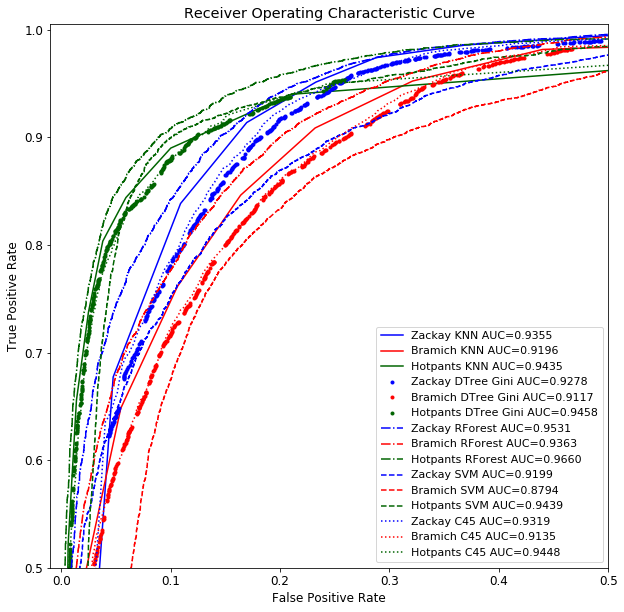

In [160]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sub_methods = [zky, bch, hot]

colors = ['blue', 'red', 'darkgreen']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest],
              'DTree Gini': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform]}


ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(10, 10))
for k, v in ml_methods.iteritems():
    for i in range(3):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        roc_auc = sub_method['roc_auc']
        sub_meth_col.append(roc_auc)
        
        label = sub_meth_col[0]+' '+k+' AUC={:06.4f}'.format(roc_auc)
        plt.plot(fpr, tpr, ls[j], lw=1.5, color=colors[i], label=label)
    j+=1

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=11)
plt.title('Receiver Operating Characteristic Curve')

plt.xlim([-0.01, 0.50])
plt.ylim([0.5, 1.005])
plt.savefig('roc_with_pca.png')

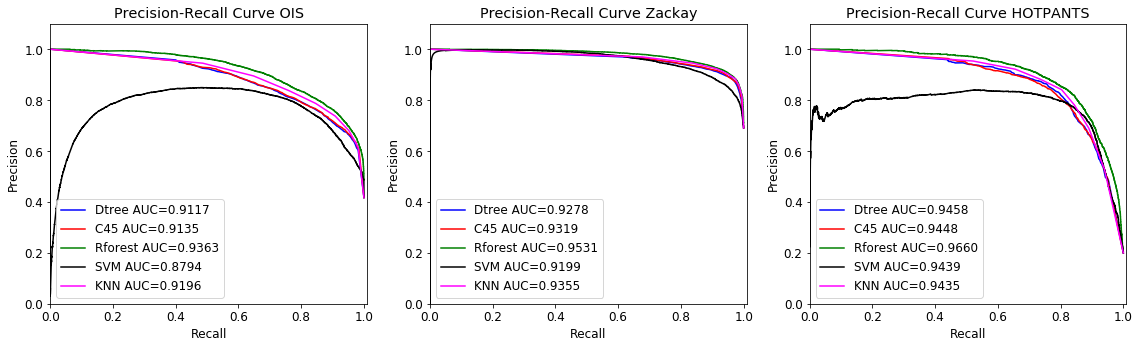

In [161]:
plt.figure(figsize=(16, 5))
#plt.figaspect(.8)
plt.subplot(131)
res_Dtree = rslts_ois_dtree_gini
res_C45 = rslts_ois_c45
res_Rforest = rslts_ois_rforest
res_svc = rslts_ois_svc
res_knn = rslts_knn_ois_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve OIS')

plt.subplot(132)
res_Dtree = rslts_zps_dtree_gini
res_C45 = rslts_zps_c45
res_Rforest = rslts_zps_rforest
res_svc = rslts_zps_svc
res_knn = rslts_knn_zps_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))
0
pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve Zackay')


plt.subplot(133)
res_Dtree = rslts_hot_dtree_gini
res_C45 = rslts_hot_c45
res_Rforest = rslts_hot_rforest
res_svc = rslts_hot_svc
res_knn = rslts_knn_hot_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve HOTPANTS')

plt.tight_layout()

plt.savefig('prec_rec_with_pca.png')

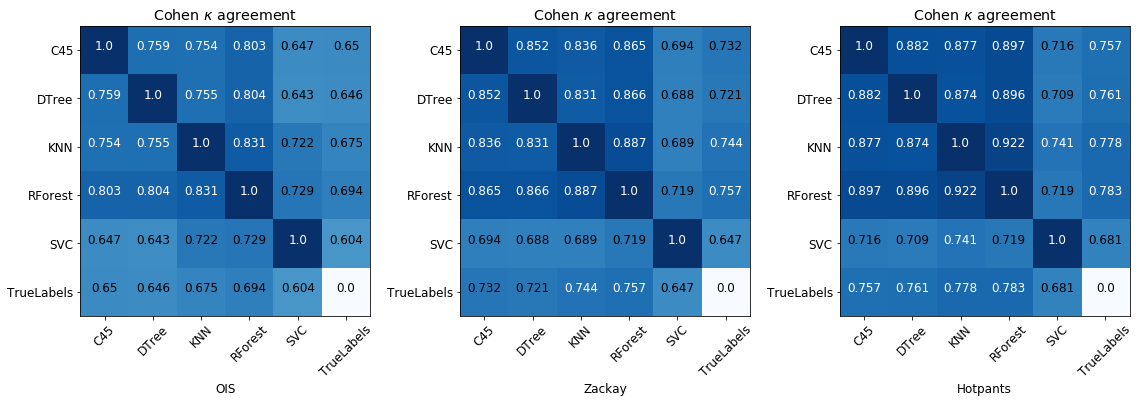

In [162]:
m_coll = []

res_Dtree = rslts_ois_dtree_gini
res_C45 = rslts_ois_c45
res_Rforest = rslts_ois_rforest
res_svc = rslts_ois_svc
res_knn = rslts_knn_ois_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])

res_Dtree = rslts_zps_dtree_gini
res_C45 = rslts_zps_c45
res_Rforest = rslts_zps_rforest
res_svc = rslts_zps_svc
res_knn = rslts_knn_zps_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])
 
res_Dtree = rslts_hot_dtree_gini
res_C45 = rslts_hot_c45
res_Rforest = rslts_hot_rforest
res_svc = rslts_hot_svc
res_knn = rslts_knn_hot_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])
names = ['OIS', 'Zackay', 'Hotpants']

plt.figure(figsize=(16, 6))
for k, methods in enumerate(m_coll):
    kappa_agreement = np.ones((len(methods), len(methods)))

    for i in range(len(methods)):
        for j in range(i+1):
            kappa_agreement[i, j] = metrics.cohen_kappa_score(methods[i]['predictions'],
                                                              methods[j]['predictions'])#, 
                                                              #labels=['star', 'galaxy'])
            kappa_agreement[j, i] = kappa_agreement[i, j]
    kappa_agreement[-1, -1] = 0
    plt.subplot(1, 3, k+1)
    
    plot_confusion_matrix(np.round(kappa_agreement, 3), 
                          classes=['C45', 'DTree', 'KNN', 'RForest', 'SVC', 'TrueLabels'],
                          title=r'Cohen $\kappa$ agreement')
    #plt.tight_layout()
    plt.xlabel(names[k])
    plt.ylabel('')


plt.savefig('cohen_with_pca.png')

In [163]:
aucs = pd.DataFrame([zky, bch, hot], columns=['SubMethod','DTreeGini', 'C45', 'RandomForest', 'KNN', 'SVM'], )

In [164]:
AUCTable = aucs.set_index(['SubMethod'])

In [165]:
AUCTable

DTreeGini       C45  RandomForest       KNN       SVM
SubMethod                                                       
Zackay      0.935540  0.927844      0.953140  0.919880  0.931882
Bramich     0.919568  0.911709      0.936350  0.879380  0.913507
Hotpants    0.943522  0.945766      0.966043  0.943903  0.944770

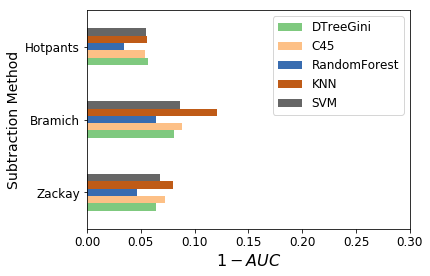

In [166]:
(1-AUCTable).plot.barh(log=False, cmap='Accent')
plt.xlabel(r'$1-AUC$', fontsize=16)
plt.ylabel('Subtraction Method', fontsize=14)
plt.tight_layout()
plt.xlim(0, 0.3)
plt.legend(loc='best', fontsize=12)
plt.savefig('./plots/complementary_AUC2_withPCA.png', dpi=600)

## Cost curves

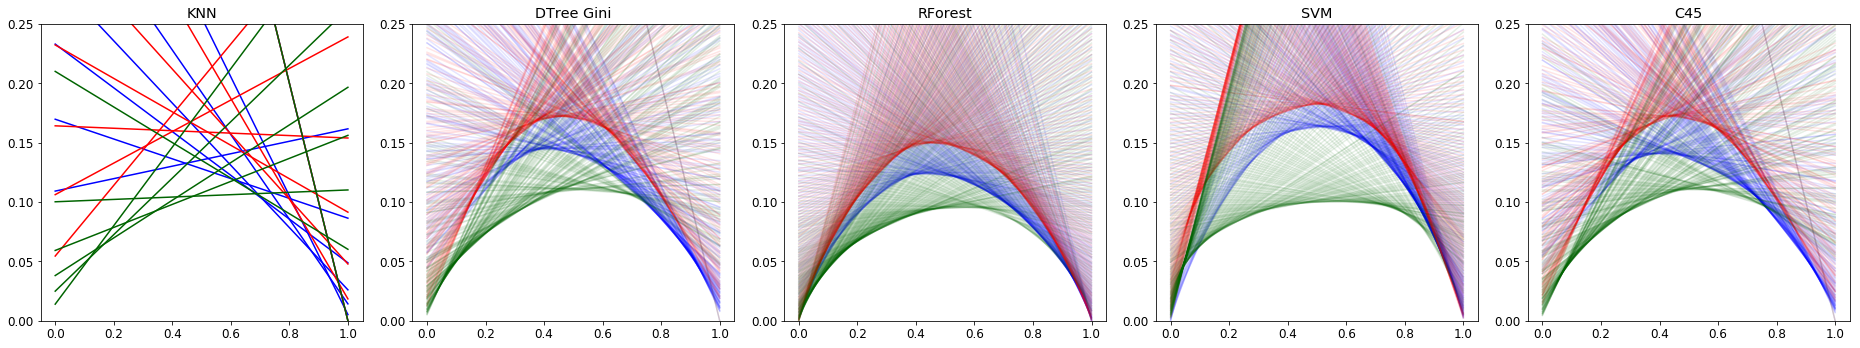

In [167]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sub_methods = [zky, bch, hot]

colors = ['blue', 'red', 'darkgreen']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest],
              'DTree Gini': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform]}


ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(26, 5))
for k, v in ml_methods.iteritems():
    plt.subplot(1, 5, j+1)
    plt.title(k)
    for i in range(3):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        thr = sub_method['thresh']
        prev_thr = 1.
        if k=='KNN':
            alpha = 1
        else: alpha=0.1
        for fp, tp, th in zip(fpr, tpr, thr):
            if (prev_thr-th) >= 0.005:
                x_ax = np.linspace(0,1,10)
                y_ax = (1-tp-fp)*x_ax + fp

                plt.plot(x_ax, y_ax, '-', color=colors[i], alpha=alpha)
                prev_thr = th
    plt.ylim(0, 0.25)
    j+=1
plt.tight_layout()

plt.savefig('cost_with_pca.png')

In [142]:
gc.collect()

120484